In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.optimize as sci
import seaborn as sns

In [2]:
sns.set_style('darkgrid')

In [3]:
# function generates a data set of size num_obs - 1
# forecast horizon is 1 months but can be changed
# num_obs cannot be larger than df.shape[0]
def generate_data(df, df_stationary, model_fitted, numb_obs, forecast_window = 1):

    lag_order = model_fitted.k_ar

    # inputs to generate a random vector
    mean_vector = np.zeros(df_stationary.shape[1])
    covariance_matrix = df_stationary.cov()

    # instantiate dataframes to store the results
    df_results = pd.DataFrame(columns=df.columns, index=range(numb_obs))
    df_forecast = pd.DataFrame(columns=df.columns, index=range(numb_obs))

    # all subsequent data points in forecast
    for i in range(lag_order, numb_obs):
        forecast_input = df_stationary.values[i-lag_order: i] 
        fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
        df_forecast.iloc[i-lag_order,:] = fc + np.random.multivariate_normal(mean_vector, covariance_matrix)
        df_results.iloc[i,:] = df.iloc[i-lag_order,:] + fc[0] + np.random.multivariate_normal(mean_vector, covariance_matrix)

    return df_results

In [4]:
# function findes in the array vec the entry with the highest values
# and returns are one-hot-encoded array where the 1 is in the position of the highest value

def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0, 0]
    elif order == 1:
        return [0, 1, 0, 0]
    elif order == 2:
        return [0, 0, 1, 0]
    elif order == 3:
        return [0, 0, 0, 1]

In [5]:
def calc_return(df, i , prob):
    delta = (df.iloc[i+1,:] - df.iloc[i,:])/df.iloc[i,:] # percentage change
    period_return = delta[0:4].to_numpy().astype(float)
    #period_utility = crra_utility(period_return)
    weighted_period_utility = torch.multiply(torch.FloatTensor(period_return), prob )
    return weighted_period_utility

In [6]:
# function estimates VAR and returns model and dataset
def estimate_VAR(data):
    # take difference of timeseries to avoid stationarity
    data_stationary = data.diff().dropna()

    # fit VAR
    var_model = VAR(data_stationary)
    var_model_fitted = var_model.fit()
    return var_model_fitted

In [7]:
# Defines a class of neuronal nets
# first and last layer defined by problem, hidden layers to be choosen
# flag states whether cross-entropy should be used in loss function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NeuronalNet(nn.Module):
    def __init__(self, batch_size):
        # inherits from nn.Module
        # invoke initiator of parent class
        super().__init__()
        self.batch_size = batch_size
    
    # define model
        l1 = 8 # input depending on number of time series
        l2 = 20#10
        l3 = 60#25
        l4 = 4
        l5 = 4 # four assets

        self.model = nn.Sequential(
            nn.Linear(l1,l2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(l2,l3),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.Linear(l3, l4),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(l3, l4),
            nn.Softmax(dim=0)
        )
      
        # define loss function
        self.loss_function = nn.MSELoss()
        
        # define optimizer
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001) 

        # counter and store loss
        self.counter = 0
        self.loss_out  = [np.inf]

    # forward pass
    def forward(self, inputs):
        return self.model(inputs)
    
    # trainings function
    def train(self, inputs, targets):
        # calc loss
        loss = self.loss_function(inputs, targets)
        # count and store loss
        self.counter += 1
        self.loss_out.append(loss.item())
        # learn
        self.optimiser.zero_grad() # optimizer reset
        loss.backward() # backpropagation
        self.optimiser.step() # re-adjust weights
        pass
    
    # return current loss
    def get_loss(self):
        return np.average(self.loss_out[- self.batch_size :])

    # plot loss function
    def plot(self):
        plt.figure(figsize=(10,8))
        df = pd.DataFrame(self.loss_out, columns = ['loss'])
        df = df[df['loss'] < 20000]
        plt.plot(df.index, df['loss'], label='loss')
        plt.xlabel('number of iterations', loc='right', fontsize=16)
        plt.ylabel('value of the loss function', loc='top', fontsize=16)
        plt.title('Performance of RL model', fontsize=20)
        plt.legend(fontsize=14)
        plt.show()

In [8]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)
        return model

In [9]:
def Reinforcement_Learning(df, numb_obs, synthetic_data = True):
    # define learning process
    epochs = 2500

    batch_size = 50
    patience = 250

    # instantiate early_stopping
    early_stopping = EarlyStopping(patience=patience * batch_size)

    # get a new model
    nn_model = NeuronalNet(batch_size = batch_size)

    if synthetic_data:
    # take difference of timeseries to avoid stationarity
    # fit VAR-model
        df_stationary = df.diff().dropna()
        df_stationary.index = pd.DatetimeIndex(df_stationary.index.values,
                                freq=df_stationary.index.inferred_freq) # to avoid error message that freq. needs to be inferred
        var_model = estimate_VAR(data=df_stationary)

    # instantiate a standard scaler
    standard_scaler = preprocessing.StandardScaler()

    for _ in range(epochs):
        if early_stopping.early_stop:
            break

        if synthetic_data:
            # get a new data set
            data = generate_data(df=df, df_stationary=df_stationary, model_fitted=var_model, numb_obs=numb_obs)

            # scale data
            x = data.values #returns a numpy array
        else:
            x = df.values
        
        x_scaled = standard_scaler.fit_transform(x)
        data = pd.DataFrame(x_scaled)  

        # initialize arrays to store results
        sum_largest_prob = torch.zeros(4, dtype=float)
        target_array = torch.zeros(4, dtype=float)

        # i=0 first probability is pure random
        #prob = torch.rand(4, requires_grad=False)
        prob = torch.ones(4, requires_grad=False)
        prob /= torch.sum(prob) # normalize so that sum is equal to 1

        i=1
        obs = data.iloc[i,:].to_numpy().astype(float)
        profit_period = calc_return(df = data, i = i , prob = prob)
        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
        # calculate discounted profit of each asset class
        sum_largest_prob += profit_period
        target_array += vec

        for i in range(2, numb_obs-1):
            # calculate profit from current portfolio in each asset class
            obs = data.iloc[i,:].to_numpy().astype(float)
            prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
        
            if i < numb_obs:   
                profit_period = calc_return(df = data, i = i , prob = prob)
            else:
                profit_period = torch.zeros(4, dtype=float)
            

            # find best strategy
            profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
            vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
            # calculate discounted profit of each asset class
            sum_largest_prob += profit_period
            target_array += vec
            
            if i % batch_size ==0:
                # learn
                nn_model.train(torch.div(sum_largest_prob, batch_size), torch.div(target_array, batch_size))
                # initialize to get fresh results
                sum_largest_prob = torch.zeros(4, dtype=float)
                target_array = torch.zeros(4, dtype=float)   

            # call early stopping    
            early_stopping(nn_model.get_loss(), nn_model)

            if early_stopping.early_stop:
                print("Early Stop!")
                break
    if early_stopping.early_stop:
        nn_model = early_stopping.load_best_model(nn_model)
    return nn_model


In [10]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

data_rl_training = df_training[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]
data_rl_test = df_test[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]

# instantiate a standard scaler and scale data for RL model
standard_scaler = preprocessing.StandardScaler()
df_training_scaled = standard_scaler.fit_transform(data_rl_training)
df_test_scaled = standard_scaler.transform(data_rl_test)

# select only the assets for the risky portfolio
data_risky_assets_training = df_training[['SP500','Gold','10y treasury Index']]
data_risky_assets_training = data_risky_assets_training.pct_change().dropna()

data_risky_assets_test = df_test[['SP500','Gold','10y treasury Index']]
data_risky_assets_test = data_risky_assets_test.pct_change().dropna()

# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()

# first 10y of data used to as history for learning and first distribution of prices
start = 120 # in months

# flag if system should retrain
retrain = True
retrain_freq = 240 # in months


df_RL= data_rl_training[0:start]
# Reinforecement Learning
model = Reinforcement_Learning(df=df_RL, numb_obs=start)

profit_rl_list = []
portfolio_rl = []
profit_rl = 0

probabilities_start = []
probabilities_end = []

for i in range(start, 530):
     
    # determin the last risk free rate
    r_f = df_training['3M'][i-1]/100

    # performance of assets
    perf_all_assets = data_all_assets_training.iloc[i,:]

    # get data for nn model
    obs = pd.DataFrame(df_training_scaled).iloc[i,:].to_numpy().astype(float)
    prob = model(torch.from_numpy(obs).float()) # get probability distribution

    # store the weights of the portfolios
    portfolio_rl.append(prob)

    # calculate profit for RL
    profit_rl += perf_all_assets @ prob.detach().numpy()
    profit_rl_list.append(profit_rl) 
     # check if system is learning in epoch 0...
    if (i==start)or(i==start+240):
        store_profit_series = []
        # store profit over time
        profit = torch.zeros(1)
        for j in range(1, df_test_scaled.shape[0]-1):
            # use only data from test data set to make it comparable
            obs = df_test_scaled[j]
            prob = model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = pd.DataFrame(df_test_scaled), i = j , prob = prob))
            store_profit_series.append(profit.item()) 
            if i ==start:
                probabilities_start.append(prob.detach().numpy())
            if i ==start+240:
                probabilities_end.append(prob.detach().numpy())

    if retrain and (i % retrain_freq == 0):

        df_RL = data_rl_training[0:i]
        # Reinforecement Learning
        model = Reinforcement_Learning(df=df_RL, numb_obs=i)
    
    

#model.plot()

Early Stop!
Early Stop!
Early Stop!


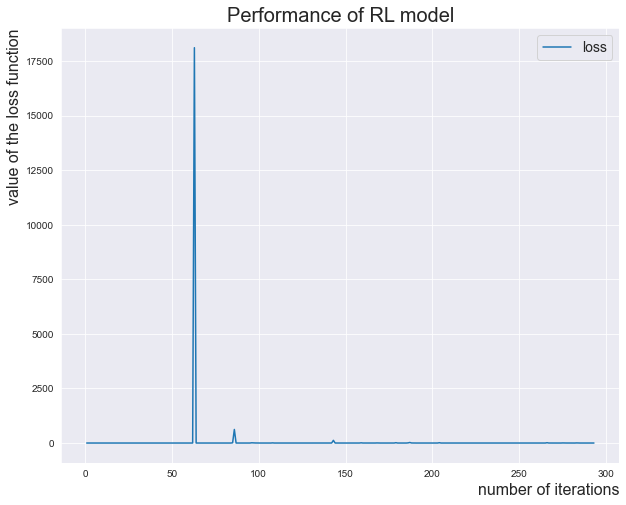

In [11]:
plt.figure(figsize=(10,8))
df_loss = pd.DataFrame(model.loss_out, columns = ['loss'])
#df_loss = df_loss[df_loss['loss'] < 1000]
plt.plot(df_loss.index, df_loss['loss'], label='loss')
plt.xlabel('number of iterations', loc='right', fontsize=16)
plt.ylabel('value of the loss function', loc='top', fontsize=16)
plt.title('Performance of RL model', fontsize=20)
plt.legend(fontsize=14)
plt.show()

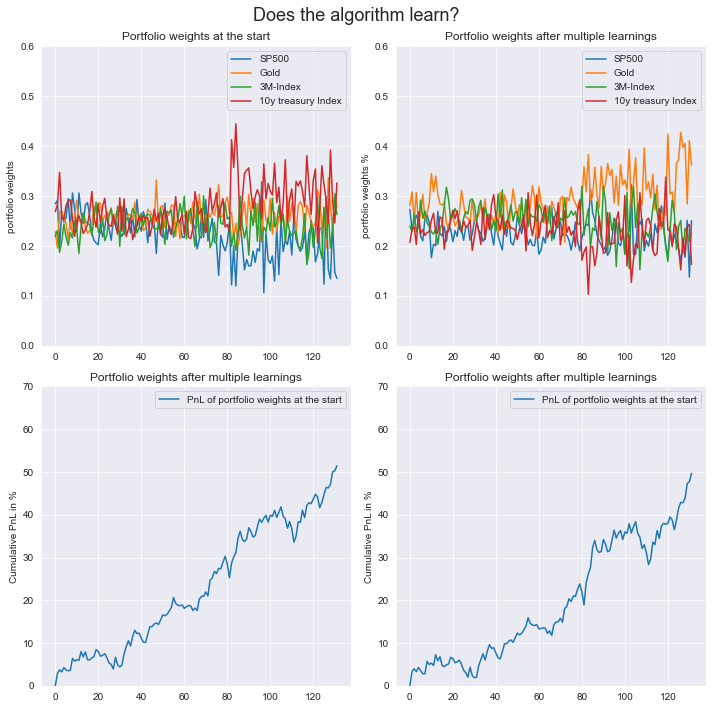

In [12]:
profit_data_start = [0]
profit_data_end = [0]
# store profit over time
profit_start = 0
profit_end = 0
for i in range(1, len(probabilities_start)):
    # use only data from test data set to make it comparable
    obs = data_all_assets_test.iloc[i:i+1]
    profit_start += np.sum(obs @ probabilities_start[i])  
    profit_end += np.sum(obs @ probabilities_end[i])  
    profit_data_start.append(profit_start * 100)
    profit_data_end.append(profit_end * 100)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

data_start = pd.DataFrame(probabilities_start, columns=['SP500', 'Gold', '3M-Index', '10y treasury Index'])
data_end = pd.DataFrame(probabilities_end, columns=['SP500', 'Gold', '3M-Index', '10y treasury Index'])

axes[0,0].plot(data_start, label=['SP500', 'Gold', '3M-Index', '10y treasury Index'])
axes[0,0].set_title('Portfolio weights at the start')
axes[0,0].set_ylabel('portfolio weights')
axes[0,0].set_ylim(0, 0.6)
axes[0,0].legend()

axes[0,1].plot(data_end, label=['SP500', 'Gold', '3M-Index', '10y treasury Index'])
axes[0,1].set_title('Portfolio weights after multiple learnings')
axes[0,1].set_ylabel('portfolio weights %')
axes[0,1].set_ylim(0, 0.6)
axes[0,1].legend()

axes[1,0].plot(profit_data_start, label='PnL of portfolio weights at the start')
axes[1,0].set_title('Portfolio weights after multiple learnings')
axes[1,0].set_ylabel('Cumulative PnL in %')
axes[1,0].set_ylim(0, 70)
axes[1,0].legend()

axes[1,1].plot(profit_data_end, label='PnL of portfolio weights at the start')
axes[1,1].set_title('Portfolio weights after multiple learnings')
axes[1,1].set_ylabel('Cumulative PnL in %')
axes[1,1].set_ylim(0, 70)
axes[1,1].legend()

plt.suptitle('Does the algorithm learn?', fontsize = 18)
plt.tight_layout()
plt.show()

[[-0.10374377  0.26194317 -0.2661191  -0.06119302]
 [ 0.26130992  0.05026066  0.26426717  0.20374103]
 [-0.20464482 -0.02676755 -0.14872618 -0.26319776]
 [-0.059496   -0.24194779  0.0120739   0.03265368]]


<AxesSubplot:>

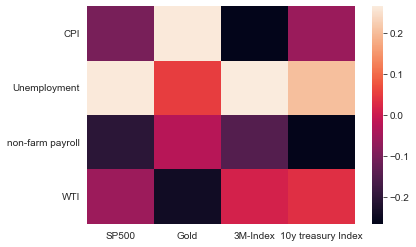

In [13]:
x_categories = ['SP500','Gold','3M-Index','10y treasury Index']
temp =  [tensor.tolist() for tensor in probabilities_end]
df_rl =pd.DataFrame(temp, columns=x_categories)

y_categories= ['CPI','Unemployment', 'non-farm payroll', 'WTI']
temp = df_test[['CPI','Unemployment', 'non-farm payroll', 'WTI']]
temp = temp.iloc[0:len(df_rl)]

y = temp.to_numpy()
x = df_rl.to_numpy()

correlation_matrix = np.corrcoef(x, y, rowvar=False)
# Extrahiere nur die Korrelationen zwischen den entsprechenden Spalten
correlations = correlation_matrix[:4, 4:]

print(correlations)
sns.heatmap(correlations,xticklabels=x_categories, yticklabels=y_categories)